## Hackathon

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

xr.set_options(display_style="text")

## Data loader om data uit de grote set te halen.

Gebruik `loader.get_subset()` voor specifieke ranges van tijd, longitude en latitude. 

Gebruik `subset.to_dataframe()` om een tabel van type xarray om te zetten naar een pandas dataframe. 

In [3]:
class DataLoader:
    """Simple dataloader for NetCDF temperature data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
    
    def load_data(self):
        """Load and preprocess the dataset."""
        self.dataset = xr.open_dataset(self.file_path, engine="h5netcdf")
        
        # Fix coordinates
        if self.dataset["longitude"].max() > 180:
            self.dataset = self.dataset.assign_coords(
                longitude=(self.dataset["longitude"].values + 180) % 360 - 180
            )
        if self.dataset["latitude"].max() > 90:
            self.dataset = self.dataset.assign_coords(
                latitude=self.dataset["latitude"].values - 90
            )
        
        # Sort coordinates
        self.dataset = self.dataset.sortby(["latitude", "longitude"])
        return self.dataset
    
    def get_subset(self, time_range=None, lat_range=None, lon_range=None):
        """Get a subset of the data."""
        if self.dataset is None:
            raise ValueError("Load data first!")
        
        subset = self.dataset
        if time_range:
            subset = subset.sel(valid_time=slice(time_range[0], time_range[1]))
        if lat_range:
            subset = subset.sel(latitude=slice(lat_range[0], lat_range[1]))
        if lon_range:
            subset = subset.sel(longitude=slice(lon_range[0], lon_range[1]))
        
        return subset.compute()
    


In [4]:
# Example usage
loader = DataLoader("2023_2m_temperature.nc")
dataset = loader.load_data()

In [5]:
print(dataset['longitude'].min().item())
print(dataset['longitude'].max().item())
print(dataset['latitude'].min().item())
print(dataset['latitude'].max().item())

-25.0
37.25
34.0
71.25


In [6]:
# Get a subset (May 2023, Europe)
subset = loader.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(52.25, 52.25),
    lon_range=(5.0, 5.0)
)
subset

<xarray.Dataset>
Dimensions:     (valid_time: 744, latitude: 1, longitude: 1)
Coordinates:
    number      int64 0
  * valid_time  (valid_time) datetime64[ns] 2023-05-01 ... 2023-05-31T23:00:00
  * latitude    (latitude) float64 52.25
  * longitude   (longitude) float64 5.0
    expver      (valid_time) object '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    t2m         (valid_time, latitude, longitude) float32 282.2 281.8 ... 284.2
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-19T08:59 GRIB to CDM+CF via cfgrib-0.9.1...

In [7]:
subset["t2m"].data.flatten()[0:10]

array([282.20166, 281.77856, 281.55127, 281.06763, 280.6704 , 281.2251 ,
       282.7295 , 284.03662, 285.3191 , 286.8589 ], dtype=float32)

In [8]:
subset.to_dataframe()

,,,number,expver,t2m
valid_time,latitude,longitude,,,
2023-05-01 00:00:00,52.25,5.0,0,0001,282.201660
2023-05-01 01:00:00,52.25,5.0,0,0001,281.778564
2023-05-01 02:00:00,52.25,5.0,0,0001,281.551270
2023-05-01 03:00:00,52.25,5.0,0,0001,281.067627
2023-05-01 04:00:00,52.25,5.0,0,0001,280.670410
...,...,...,...,...,...
2023-05-31 19:00:00,52.25,5.0,0,0001,288.152588
2023-05-31 20:00:00,52.25,5.0,0,0001,286.337646
2023-05-31 21:00:00,52.25,5.0,0,0001,285.362793


## Methode om je forecast functie te evalueren op een random steekproef van de dataset. 
In dit voorbeeld wordt steeds 2 weken historische data gepakt en wordt 1 week vooruit voorspeld.

`generate_eval_data()` geeft n random periodes van 3 weken op willekeurige locaties.

`forecast(history, n_points)` neemt een historische reeks van temperaturen en voorspelt de volgende n_points.

`forecast_1w()` evalueert de forecast functie op een random week (MAE score) en toont een grafiek van de historische reeks, de echte waardes en de voorspelde waarde. 

`evaluator(function, n_samples)` berekent de mean absolute error (MAE) van de voorspelling van functie `forecast()` voor een steekproef van grootte n_samples. 

In [9]:
def generate_eval_data(n = 100):
    rng = np.random.default_rng()
    
    # ---- Random geolocation ----
    # Longitude uniform in [-180, 180)
    lon = rng.uniform(-25, 37.25, n)
    lon = np.round(lon * 4)/4
    
    # Latitude area-uniform: sample z = sin(lat) ~ U(-1,1)  => lat = arcsin(z)
    lat = rng.uniform(34, 71.25, n)
    lat = np.round(lat * 4)/4
    
    # ---- Random 3-week interval in 2023 ----
    start0 = pd.Timestamp("2023-01-01")
    # Inclusive end = start + 20 days (21 calendar days total)
    last_start = pd.Timestamp("2023-12-31") - pd.Timedelta(days=20)
    num_choices = (last_start - start0).days + 1
    
    offsets = rng.integers(0, num_choices, n)  # days after Jan 1
    start_date = start0 + pd.to_timedelta(offsets, unit="D")
    end_date = start_date + pd.Timedelta(days=20)
    
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d")
    })
    return df

In [10]:
generate_eval_data(5)

,latitude_deg,longitude_deg,start_date,end_date
0,39.75,29.00,2023-05-21,2023-06-10
1,57.75,-14.00,2023-11-06,2023-11-26
2,42.25,7.25,2023-07-25,2023-08-14
3,49.25,7.00,2023-06-18,2023-07-08
4,64.75,-8.75,2023-11-08,2023-11-28


In [11]:
def forecast(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    # Take the last point of the history and repeat it n_points times
    try:
        return np.full(n_points, history[-1])
    except: 
        return np.full(n_points, 0)

def forecast_1w(row, function, operation = 'loop'):
    sample = loader.get_subset(
            time_range=(row['start_date'], row['end_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()
    history = sample.sel(valid_time=slice(row['start_date'],(pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['t2m'].data.flatten()
    y_true = sample.sel(valid_time=slice((pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),row['end_date']))['t2m'].data.flatten()
    y_pred = function(history, len(y_true))
    if operation == 'manual':
        fig, ax = plt.subplots()
        ax.plot(range(len(history)), history, color = 'blue')
        ax.plot(range(len(history), len(history) + len(y_true)), y_true, color = 'blue', linestyle = 'dashed')
        ax.plot(range(len(history), len(history) + len(y_true)), y_pred, color = 'green', linestyle = (0, (1, 1)))
    return np.mean(np.abs(y_true - y_pred))

In [12]:
forecast(np.array([9,8,18]), n_points = 5)

array([18, 18, 18, 18, 18])

0.745885

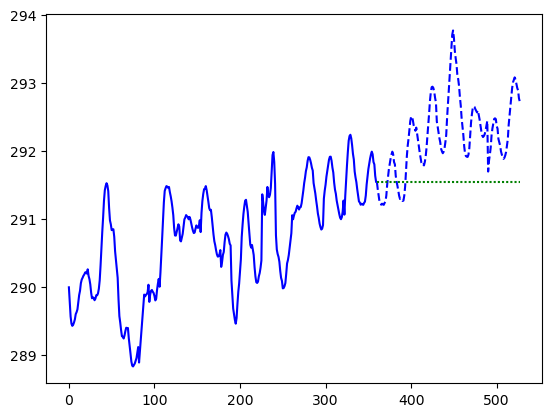

In [13]:
forecast_1w(generate_eval_data(1).iloc[0], forecast, 'manual')

In [14]:
def evaluator(function, n_samples = 100):
    errors = []
    df = generate_eval_data(n_samples)
    for index, row in df.iterrows():
        error = forecast_1w(row, function, operation = 'loop')
        errors.append(error)
    return np.mean(errors)

In [15]:
evaluator(forecast, 10)

2.5321586

In [16]:
from sklearn.linear_model import LinearRegression

def linear_forecast(history, n_points=24):
    # Gebruik de laatste 24 uur als features
    window = 24
    X = []
    y = []
    # Zorg dat er genoeg data is om te trainen
    for i in range(len(history) - window - n_points + 1):
        X.append(history[i:i+window])
        y.append(history[i+window:i+window+n_points])
    if len(X) == 0:
        # Te weinig data, gebruik laatste waarde als fallback
        return np.full(n_points, history[-1])
    X = np.array(X)
    y = np.array(y)
    # Train het model
    model = LinearRegression()
    model.fit(X, y)
    # Voorspel de volgende n_points
    forecast = model.predict([history[-window:]])[0]
    return forecast

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets

def plot_cartopy_hour(month=5, day=15, hour=12):
    month_str = f"{month:02d}"
    day_str = f"{day:02d}"
    hour_str = f"{hour:02d}:00"
    time_str = f"2023-{month_str}-{day_str}T{hour_str}"
    subset = dataset.sel(valid_time=time_str)
    lats = subset['latitude'].values
    lons = subset['longitude'].values
    temps = subset['t2m'].values - 273.15  # Kelvin naar Celsius

    lon_grid, lat_grid = np.meshgrid(lons, lats)
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    # Visueel vriendelijker kleurverloop
    temp_plot = ax.pcolormesh(
        lon_grid, lat_grid, temps,
        cmap='RdYlBu_r', shading='auto',
        vmin=-20, vmax=40,
        transform=ccrs.PlateCarree()
    )   
    plt.colorbar(temp_plot, ax=ax, orientation='vertical', label='Temperatuur (°C)')
    plt.title(f'Temperatuur {time_str}')
    plt.show()

month_slider = widgets.IntSlider(value=5, min=1, max=12, step=1, description='Maand:')
day_slider = widgets.IntSlider(value=15, min=1, max=31, step=1, description='Dag:')
hour_slider = widgets.IntSlider(value=12, min=0, max=23, step=1, description='Uur:')
widgets.interact(plot_cartopy_hour, month=month_slider, day=day_slider, hour=hour_slider)

interactive(children=(IntSlider(value=5, description='Maand:', max=12, min=1), IntSlider(value=15, description…

<function __main__.plot_cartopy_hour(month=5, day=15, hour=12)>

In [19]:
evaluator(linear_forecast, 10)

3.1184378

Grootste temperatuurverschil: 64.28 °C
Locatie: latitude=57.75, longitude=36.5
Warmste moment: 2023-08-06T10:00:00.000000000 (31.48 °C)
Koudste moment: 2023-01-07T07:00:00.000000000 (-32.80 °C)


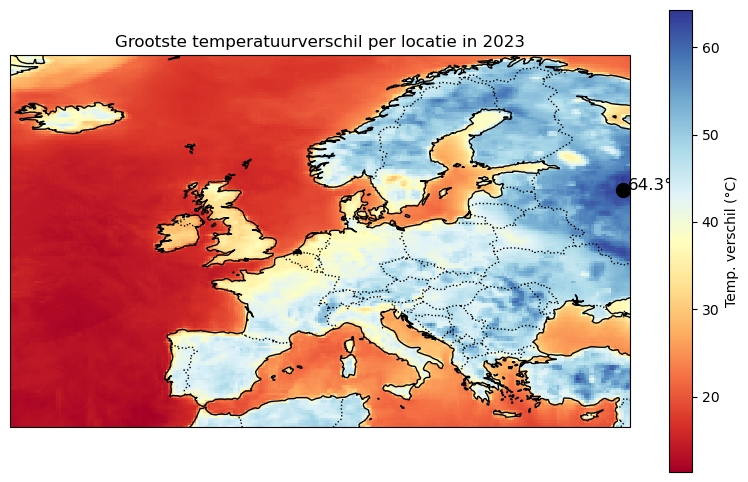

In [34]:
# Zoek het grootste temperatuurverschil per locatie over het jaar
temps_c = dataset['t2m'] - 273.15  # Kelvin naar Celsius
max_temp = temps_c.max(dim='valid_time')
min_temp = temps_c.min(dim='valid_time')
diff_temp = max_temp - min_temp

# Grootste verschil en bijbehorende locatie
max_diff = diff_temp.max()
loc = np.unravel_index(np.argmax(diff_temp.values), diff_temp.shape)
lat = diff_temp['latitude'].values[loc[0]]
lon = diff_temp['longitude'].values[loc[1]]

print(f"Grootste temperatuurverschil: {max_diff.item():.2f} °C")
print(f"Locatie: latitude={lat}, longitude={lon}")

# Zoek tijdstippen van max en min temperatuur op deze locatie
temps_loc = temps_c.sel(latitude=lat, longitude=lon)
valid_times = temps_loc['valid_time'].values
max_idx = np.argmax(temps_loc.values)
min_idx = np.argmin(temps_loc.values)
max_time = valid_times[max_idx]
min_time = valid_times[min_idx]

print(f"Warmste moment: {max_time} ({temps_loc.values[max_idx]:.2f} °C)")
print(f"Koudste moment: {min_time} ({temps_loc.values[min_idx]:.2f} °C)")

# Plot een kaart van het temperatuurverschil
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

lats = diff_temp['latitude'].values
lons = diff_temp['longitude'].values
diff_vals = diff_temp.values

lon_grid, lat_grid = np.meshgrid(lons, lats)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
temp_plot = ax.pcolormesh(
    lon_grid, lat_grid, diff_vals,
    cmap='RdYlBu', shading='auto',
    transform=ccrs.PlateCarree()
)
plt.colorbar(temp_plot, ax=ax, orientation='vertical', label='Temp. verschil (°C)')
plt.title('Grootste temperatuurverschil per locatie in 2023')

# Marker op de locatie met het grootste verschil
ax.plot(lon, lat, marker='o', color='black', markersize=10, label='Max verschil')
ax.text(lon+0.5, lat, f'{max_diff.item():.1f}°C', color='black', fontsize=12)

plt.show()